In [1]:
import numpy as np
import hypernetx as hnx
from networkx import fruchterman_reingold_layout as layout
from itertools import combinations

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#global variables
node_nb = 0

#gates
X = np.array([[0, 1],
            [1, 0]],dtype=np.complex_)

Z = np.array([[1, 0],
            [0, -1]],dtype=np.complex_)

I = np.array([[1, 0],
            [0, 1]],dtype=np.complex_)

H = np.array([[1/np.sqrt(2), 1/np.sqrt(2)],
            [1/np.sqrt(2), -1/np.sqrt(2)]],dtype=np.complex_)

CX = np.array([[1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 1, 0]],dtype=np.complex_)

CZ = np.array([[1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, -1]],dtype=np.complex_)

CCZ = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, -1]],dtype=np.complex_)

SWAP = np.array([[1, 0, 0, 0],
            [0, 0, 1, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1]],dtype=np.complex_)

initial_state = np.array([1, 0],dtype=np.complex_)
excited_state = np.array([0, 1],dtype=np.complex_)

def getUID(prefix='id'):
    global node_nb
    
    node_nb = node_nb + 1
    return prefix+"_"+str(node_nb - 1)

def getNodeLabels(system):
    labels = {}
    for n in system.nodes:
        labels[n] = system.nodes[n].uid + '  [' + system.nodes[n].qubit + ']  ' + str(np.around(system.nodes[n].state,3))
        
    return labels

def getEdgeLabels(system):
    labels = {}
    for n in system.edges:
        labels[n] = n+'  '+str(np.around(system.edges[n].amplitude,3))
        
    return labels

def P2R(radii, angles):
    return radii * np.exp(1j*angles)

def R2P(x):
    return np.abs(x), np.angle(x)
    
class Node:
    
    def __init__(self,qubit,state):
        self.uid = getUID('node')
        self.qubit = qubit
        self.state = state
        self.edge_uid = None
        
class Hyperedge:
    
    def __init__(self,amplitude,uid=None):
        self.node_uids = []
        if (uid is None):
            self.uid = getUID('edge')
        else:
            self.uid = uid
        self.amplitude = amplitude
        
class Hypergraph:
    
    def __init__(self,nb_qubits, sv=[]):
        self.nodes = {}
        self.edges = {}
        
        if (len(sv) > 0):
            for i in range(0,len(sv)):
                prob = sv[i].real**2 + sv[i].imag**2
                if (prob):

                    e = Hyperedge(sv[i])
                    self.edges[e.uid] = e

                    #create nodes
                    bits = [(i >> bit) & 1 for bit in range(nb_qubits - 1, -1, -1)]
                    j = 0
                    for bit in bits:
                        p = Node("q"+str(j),(excited_state if bit == 1 else initial_state))
                        #add nodes to hgraph
                        self.nodes[p.uid] = p
                        #add nodes to edge
                        self.addNodeToEdge(p.uid,e.uid)
                        j = j + 1
        else:
            for i in range(0,nb_qubits):
                node = Node("q"+str(i),np.array([1, 0],dtype=np.complex_))
                self.nodes[node.uid] = node
            
    
    def normalize_complex_arr(self,a):
        norm = np.linalg.norm(a)
        return a / norm

    def getQubitNodeIds(self,qubit):
        uids = []
        for n in self.nodes:
            if (self.nodes[n].qubit == qubit):
                uids.append(self.nodes[n].uid)
        
        return uids
    
    def getQubitNodeIdInEdge(self,qubit,edge_uid):
        for n in self.nodes:
            if (self.nodes[n].qubit == qubit):
                if ((self.nodes[n].edge_uid is None and edge_uid is None) or (self.nodes[n].edge_uid == edge_uid)):
                    return self.nodes[n].uid
        
        return None

    def getQubitNodeId(self,qubit,edge):
        uids = []
        for n in self.edges[edge].node_uids:
            if (self.nodes[n].qubit == qubit):
                return self.nodes[n].uid
        
        return None
    
    def getQubitEdgeIds(self,qubit):
        uids = []
        for e in self.edges:
            node_uids = self.edges[e].node_uids
            for node_uid in node_uids:
                if (self.nodes[node_uid].qubit == qubit):
                    uids.append(e)
        
        return uids

    def addNodeToEdge(self, node_uid, edge_uid):
        #assume edge and node exist
        if (self.nodes[node_uid].edge_uid == None):
            self.nodes[node_uid].edge_uid = edge_uid
            self.edges[edge_uid].node_uids.append(node_uid)
        
    def deleteNode(self, node_uid):
        #assuming nodes only belong to one element
        
        if (node_uid in self.nodes.keys()):
            e_uid = self.nodes[node_uid].edge_uid

            self.nodes.pop(node_uid)

            if (e_uid in self.edges.keys()):
                i = self.edges[e_uid].node_uids.index(node_uid)
                self.edges[e_uid].node_uids.pop(i)
        
    def deleteEdge(self, edge_uid):
        if ((edge_uid in self.edges.keys()) and len(self.edges[edge_uid].node_uids) == 0):
            self.edges.pop(edge_uid)
            
    def applyGate(self, qubit, gate):
        for n in self.nodes:
            if (self.nodes[n].qubit == qubit):
                #we apply the gate
                self.nodes[n].state = np.dot(gate,self.nodes[n].state)
    
    #We must conbine them in distributabliy
    def combineEdges(self, a_edge_ids, b_edge_ids):
        for a_id in a_edge_ids:
            for b_id in bedge_ids:
                a_edge = self.edges[a_id]
                b_edge = self.edges[b_id]
                
                e = Hyperedge(a_edge.amplitude*b_edge.amplitude)
                self.edges[e.uid] = e

                #recrerate the nodes of a inside the new edge
                for n_id in a_edge.node_uids:
                    p = Node(self.nodes[n_id].qubit,self.nodes[n_id].state)
                    self.nodes[p.uid] = p
                    self.addNodeToEdge(p.uid,e.uid)
                
                #recrerate the nodes of b inside the new edge
                for n_id in b_edge.node_uids:
                    p = Node(self.nodes[n_id].qubit,self.nodes[n_id].state)
                    self.nodes[p.uid] = p
                    self.addNodeToEdge(p.uid,e.uid)
        
        #Cleanup and delete the old nodes and edges
        for e_id in a_edge_ids:
            edge = self.edges[e_id]
            for n_id in edge.node_uids:
                self.deleteNode(n_id)
            
            self.deleteEdge(e_id)
        
        for e_id in b_edge_ids:
            edge = self.edges[e_id]
            for n_id in edge.node_uids:
                self.deleteNode(n_id)
            
            self.deleteEdge(e_id)

    #We assume a != b
    def apply2QubitGate(self, a, b, gate):
        #if one of the qubits is not entangled but the other is we need to add the qubit to all corresponding edges before we start with the operation (sort of decompress)
        #preprocessing NOT tested
        a_edge_ids = self.getQubitEdgeIds(a)
        b_edge_ids = self.getQubitEdgeIds(b)
        
        if (len(a_edge_ids) == 0 and len(b_edge_ids) != 0):
            a_node_ids = self.getQubitNodeIds(a)
            a_node = self.nodes[a_node_ids[0]]
            for edge_id in b_edge_ids:
                #create node
                p = Node(a_node.qubit,a_node.state)
                #add nodes to hgraph
                self.nodes[p.uid] = p
                #add nodes to edge
                self.addNodeToEdge(p.uid,edge_id)
            
            #delete original node
            #did nt belong t any edge anyway
            self.deleteNode(a_node.uid)
        
        elif (len(b_edge_ids) == 0 and len(a_edge_ids) != 0):
            b_node_ids = self.getQubitNodeIds(b)
            b_node = self.nodes[b_node_ids[0]]
            for edge_id in a_edge_ids:
                #create node
                p = Node(b_node.qubit,b_node.state)
                #add nodes to hgraph
                self.nodes[p.uid] = p
                #add nodes to edge
                self.addNodeToEdge(p.uid,edge_id)
            
            #delete original node
            #did nt belong t any edge anyway
            self.deleteNode(b_node.uid)
        
        #if both entangled but in different edges we need to do some preprocessing as well
        shared_edges = list(set(a) & set(b))

        #tbh, if edges are not shared they, the intersection must be empty. Any other set-up it's just not a valid state
        if (len(shared_edges) == 0):
            self.combineEdges(a_edge_ids,b_edge_ids)
        
        # From here on we assume both are either not entangled or share the same edges
        a_node_ids = self.getQubitNodeIds(a)
        b_node_ids = self.getQubitNodeIds(b)

        for a_id in a_node_ids:
            for b_id in b_node_ids:
                if ((a_id in self.nodes.keys()) and (b_id in self.nodes.keys())):
                    if (self.nodes[a_id].edge_uid == self.nodes[b_id].edge_uid):
                        parent_amplitude = 1
                        if (self.nodes[a_id].edge_uid != None):
                            parent_amplitude = self.edges[self.nodes[a_id].edge_uid].amplitude
                        
                        #get local 2 qubit state vector
                        sv = np.kron(self.nodes[a_id].state, self.nodes[b_id].state)
                        #apply the gate
                        new_sv = np.dot(gate, sv)

                        #this is hard coded for 2 (00,01,10,11)
                        
                        #for garbage collection afterwards
                        gc_n = [a_id, b_id]
                        #for garbage collection afterwards
                        gc_e = self.nodes[a_id].edge_uid
                        
                        #process result
                        for i in range(0,4):
                            prob = new_sv[i].real**2 + new_sv[i].imag**2
                            if (prob):
                                
                                #TODO This is used in many places and can be abstracted
                                e = Hyperedge(parent_amplitude*new_sv[i])
                                self.edges[e.uid] = e

                                #create nodes
                                p = Node(a,(excited_state if i>1 else initial_state))
                                q = Node(b,(excited_state if i%2 else initial_state))
                                
                                #add nodes to hgraph
                                self.nodes[p.uid] = p
                                self.nodes[q.uid] = q
                                
                                #add nodes to edge
                                self.addNodeToEdge(p.uid,e.uid)
                                self.addNodeToEdge(q.uid,e.uid)
                                
                                #If they were inside an edge, this edge can have nodes from other qubits
                                #These nodes should also be replicated and the original ones deleted afterwards
                                e_id = self.nodes[a_id].edge_uid
                                if (e_id is not None):
                                    for n_id in self.edges[e_id].node_uids:
                                        if (n_id != a_id and n_id != b_id):
                                            n = self.nodes[n_id]
                                            #create nodes
                                            p = Node(n.qubit,n.state)
                                            #add nodes to hgraph
                                            self.nodes[p.uid] = p
                                            #add nodes to edge
                                            self.addNodeToEdge(p.uid,e.uid)
                                            gc_n.append(n_id)
                        
                        #Collect garbage
                        for g_id in gc_n:
                            self.deleteNode(g_id)

                        #All belong to same edge
                        if (gc_e is not None):
                            self.deleteEdge(gc_e)
                        
    def getGlobalPhase(self, state):
        for s in state:
            (val, angle) = R2P(s)
            
            #TODO is this a good convention?
            if (val != 0):
                return angle
        
        return None
    
    def correctPhase(self, state):
        angle = self.getGlobalPhase(state)
        
        for i, s in enumerate(state):
            (absi, angi) = R2P(s)
            state[i] = P2R(absi,angi-angle)
        
        return state
    
    def stateEq(self, state1, state2):
        #Correct for global phase
        state1 = self.correctPhase(state1)
        state2 = self.correctPhase(state2)
        
        return np.array_equal(state1,state2)
    
    #Transforms the full system
    def toStateVector(self):
        sv = np.array([])
        
        #First we deal with edges and entangled qubits
        for edge in self.edges:
            parent_amplitude = self.edges[edge].amplitude
            tmp_sv = np.array([])

            for node_uid in self.edges[edge].node_uids:
                if (len(tmp_sv) == 0):
                    tmp_sv = self.nodes[node_uid].state
                else:
                    tmp_sv = np.kron(self.nodes[node_uid].state,tmp_sv)

            tmp_sv = parent_amplitude * tmp_sv

            if (len(sv) == 0):
                sv = tmp_sv
            else:
                sv = sv + tmp_sv
        
        #Then we deal with the non-entangled ones
        #Kroenecker product of all nodes
        for node_uid in self.nodes:
            if (self.nodes[node_uid].edge_uid is None):
                if (len(sv) == 0):
                    sv = self.nodes[node_uid].state
                else:
                    sv = np.kron(self.nodes[node_uid].state,sv)
        
        return sv 
    
    # m Hyperedge matrix
    # runs one merge
    # m isdict with edges and qubits
    # a is dictionary with edge amplitudes
    
    def simplifyRec(self, m, amps):
        if (len(m.keys()) == 1):
            return (m,amps)

        res = {}
        processed = []
        #do one run
        for e1 in m:
            processed.append(e1)
            for e2 in m:
                if (e2 not in processed):
                    #can we merge e1 and e2
                    nb_diff = 0
                    a = None
                    b = None
                    e = None
                    x = amps[e1]
                    y = amps[e2]
                    nodes = {}
                    for n in m[e1]:
                        if (not self.stateEq(m[e1][n],m[e2][n])):
                            nb_diff += 1
                            nodes[n] = self.normalize_complex_arr((amps[e1]*m[e1][n]) + (amps[e2]*m[e2][n]))
                            a = np.reshape(m[e1][n],(len(m[e1][n]),1))
                            b = np.reshape(m[e2][n],(len(m[e2][n]),1))
                            e = np.reshape(nodes[n],(len(nodes[n]),1))
                        else:
                            nodes[n] = m[e1][n]
                    
                    #We process the merge really only if the edges we copared has 0 or 1 difference
                    if (nb_diff <= 1):
                        res[e1+'_'+e2] = nodes
                        
                        te = np.transpose(e)
                        amps[e1+'_'+e2] = np.dot(te,(x*a + y*b))[0]
                        
                        for e3 in m:
                            if (e3 != e1 and e3 != e2):
                                res[e3] = m[e3]
                        
                        #recursive step
                        return self.simplifyRec(res,amps)
                    
        #If we end up here it means we havent simplified anything
        return (m,amps)
    
    #m Hyperedge dict
    def deleteEdges(self,m):
        for e in m:
            for q in m[e]:
                self.deleteNode(self.getQubitNodeId(q,e))
            
            self.deleteEdge(e)
        
    #m Hyperedge dict
    def createEdges(self,m, amps):
        if (len(m.keys()) <= 1):
            for e in m:
                for q in m[e]:
                    node = Node(q,m[e][q])
                    self.nodes[node.uid] = node
        else:
            t = {}
            for e in m:
                for q in m[e]:
                    if (q not in t.keys()):
                        t[q] = {}

                    t[q][e] = m[e][q]

            #Check which qubits are entangled
            non_entangled = []
            for q in t:
                q_first = None
                all_equal = True
                for e in t[q]:
                    if (q_first is None):
                        q_first = t[q][e]
                    else:
                        all_equal = all_equal and (self.stateEq(t[q][e],q_first))
                
                if (all_equal):
                    non_entangled.append(q)

            for e in m:
                edge = Hyperedge(amps[e],e)
                self.edges[edge.uid] = edge
                for q in m[edge.uid]:
                    node = Node(q,m[edge.uid][q])
                    self.nodes[node.uid] = node
                    
                    if (q not in non_entangled):
                        self.addNodeToEdge(node.uid,edge.uid)
    
    #Move all node global phases are bubbled up to the corresponding edges!
    def factorPhases(self, qubits):
        for node_uid in self.nodes:
            edge_uid = self.nodes[node_uid].edge_uid
            if (edge_uid is not None):
                angle_n = self.getGlobalPhase(self.nodes[node_uid].state)
                self.nodes[node_uid].state = self.correctPhase(self.nodes[node_uid].state)
                
                (val_e, angle_e) = R2P(self.edges[edge_uid].amplitude)
                self.edges[edge_uid].amplitude = P2R(val_e, angle_e + angle_n)
                
    
    #TODO we gtta implement something more generic that just goes through all the edges at the system level
    def simplify(self, qubits):
        #preprocessing: Make sure all node global phases are bubbled up to the crresponding edges!
        self.factorPhases(qubits)
                
        #build matrix and check if exactly all the qubits are in hyperedges
        m = {}
        amps = {}
        error = False
        for q in qubits:
            edge_ids = self.getQubitEdgeIds(q)
            if (len(edge_ids) == 0):
                error = 'qubit ' + q + ' is not entangled'
            for e in edge_ids:
                if (e not in m.keys() and qubits.index(q) == 0):
                    m[e] = {}
                    amps[e] = self.edges[e].amplitude
                elif (e not in m.keys()):
                    error = 'The qubits are not entangled all together'
                    
                for n in self.edges[e].node_uids:
                    if (self.nodes[n].qubit not in qubits):
                        error = 'The qubits are entangled with others not specified in the input'
                    if (self.nodes[n].qubit == q):
                        m[e][q] = self.nodes[n].state

        if (error):
            print(error)
            return
            
        #call recursive part
        (m_simp,amps_simp) = self.simplifyRec(m,amps)
        
        #process output dict
        self.deleteEdges(m)
        self.createEdges(m_simp,amps_simp)
    
    def print_raw(self):
        print("nodes:")
        for n in self.nodes:
            print(self.nodes[n].state)

        print("edges:")
        for e in self.edges:
            print(self.edges[e].amplitude)
        
    def draw(self):        
        s = hnx.Entity('system', elements=[], amplitude=1)
        hg = hnx.Hypergraph()
        hg.add_edge(s)
        
        empty_system = True
        for i in self.edges:
            edge = hnx.Entity(i+'  '+str(np.around(self.edges[i].amplitude,3)))
            
            hg.add_edge(edge)
        
        for i in self.nodes:
            node = hnx.Entity(str(self.nodes[i].uid) + '  [' + str(self.nodes[i].qubit) + ']  ' + str(np.around(self.nodes[i].state,3)))

            if (self.nodes[i].edge_uid == None):
                hg.add_node_to_edge(node,'system')
                empty_system = False
            else:
                euid = self.nodes[i].edge_uid
                l_euid = euid+'  '+str(np.around(self.edges[euid].amplitude,3))
                hg.add_node_to_edge(node,l_euid)
            
        if (empty_system):
            hg.remove_edge("system")
        
        '''hnx.drawing.rubber_band.draw(hg,
             node_labels=getNodeLabels(hg),
             edge_labels=getEdgeLabels(hg),
             node_radius=2.0,
             label_alpha=1.0
        )'''
        
        hnx.drawing.two_column.draw(hg)

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


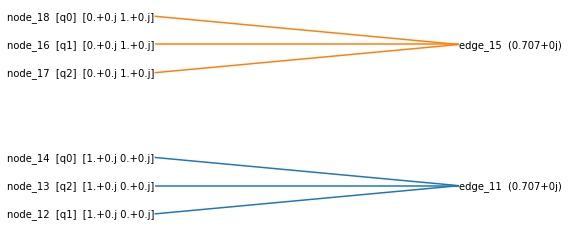

In [3]:
system = Hypergraph(3)

system.applyGate("q0",H)
system.apply2QubitGate("q0","q1",CX)
system.apply2QubitGate("q1","q2",CX)
#system.applyGate("q2",H)
#system.apply2QubitGate("q2","q1",CX)

#system.simplify(["q0","q1","q2"])

print(system.toStateVector())
system.draw()